<a href="https://colab.research.google.com/github/AhHosny/CIT690E-DL-Course/blob/master/LAB_4_SGD_vs_Adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Varying Loss Optimizer (SGD vs Adam)

In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torchvision.datasets import FashionMNIST
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Download Dataset

In [2]:
data_folder = 'data/' 
fmnist = FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

val_fmnist = FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



![fmnist](https://miro.medium.com/max/700/1*jXssb_WjoYZgepOCfdQfJA.png)

In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

In [ ]:
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size = 32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

## SGD optimizer

### Model Creation

In [ ]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

### Training Batch Function

In [ ]:

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

### Accuracy Function

In [ ]:
def accuracy(x, y, model):
    model.eval()
    # this is the same as @torch.no_grad 
    # at the top of function, only difference
    # being, grad is not computed in the with scope
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

### Validation Loss

In [ ]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

### Training

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
    train_epoch_losses, train_epoch_accuracies = [], []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)

    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
    
    print("Epoch: {} - Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, validation_loss, val_epoch_accuracy))

Epoch: 0 - Validation Loss: 0.6121, Validation Accuracy: 0.7880
Epoch: 1 - Validation Loss: 0.5427, Validation Accuracy: 0.8117
Epoch: 2 - Validation Loss: 0.4881, Validation Accuracy: 0.8299
Epoch: 3 - Validation Loss: 0.4717, Validation Accuracy: 0.8315
Epoch: 4 - Validation Loss: 0.4524, Validation Accuracy: 0.8393
Epoch: 5 - Validation Loss: 0.4426, Validation Accuracy: 0.8417
Epoch: 6 - Validation Loss: 0.4321, Validation Accuracy: 0.8472
Epoch: 7 - Validation Loss: 0.4262, Validation Accuracy: 0.8505
Epoch: 8 - Validation Loss: 0.4235, Validation Accuracy: 0.8507
Epoch: 9 - Validation Loss: 0.4111, Validation Accuracy: 0.8552


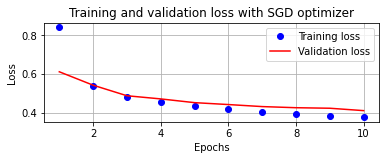

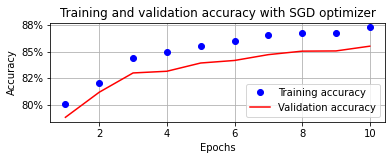

In [ ]:
epochs = np.arange(10)+1

plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss with SGD optimizer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy with SGD optimizer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

### Adam optimizer

In [ ]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
    print("Epoch: {} - Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, validation_loss, val_epoch_accuracy))

Epoch: 0 - Validation Loss: 0.4652, Validation Accuracy: 0.8356
Epoch: 1 - Validation Loss: 0.4313, Validation Accuracy: 0.8527
Epoch: 2 - Validation Loss: 0.4435, Validation Accuracy: 0.8455
Epoch: 3 - Validation Loss: 0.4574, Validation Accuracy: 0.8407
Epoch: 4 - Validation Loss: 0.4615, Validation Accuracy: 0.8433
Epoch: 5 - Validation Loss: 0.4408, Validation Accuracy: 0.8485
Epoch: 6 - Validation Loss: 0.4695, Validation Accuracy: 0.8412
Epoch: 7 - Validation Loss: 0.4516, Validation Accuracy: 0.8477
Epoch: 8 - Validation Loss: 0.4907, Validation Accuracy: 0.8485
Epoch: 9 - Validation Loss: 0.4892, Validation Accuracy: 0.8435


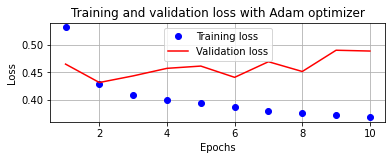

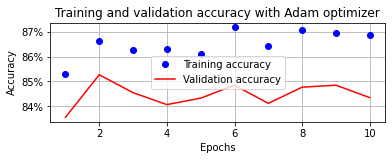

In [ ]:
epochs = np.arange(10)+1

plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss with Adam optimizer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy with Adam optimizer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# End!